In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom

n_students = 21

#
# stu_array: Infected: bool, 0 = No, 1 = Yes
#            Days infected: int, -1,0,1,2,3,4...

stu_array = np.array([[1, 1]] + [[0, 0]]*(n_students - 1))
infections = np.array([1]) # Array to track the number infected per day. Update upon a new infection.

def sim_day(students, infects, day=0):
    """Simulates a day at school and the infections that may occur.
        Given: students: stu_array of type np.array;
                infects: number of students who've been infected of type int
        Returns: students, infects
    """
    p = 0.02

    if day != 0 and (day+1) % 6 == 0:
        #do nothing
        # print(f'Day = {day}: 6 do nothing')
        pass
    elif day != 0 and (day+1) % 7 == 0:
        #do nothing
        # print(f'Day = {day}: 7 do nothing')
        pass
    else:
        # print(f'Day = {day}: do the thing')
        for stu in range(len(stu_array)):
            if students[stu, 0] == 1 and students[stu,1] in range(1, 4): # Student has caught the flu and is contagious
                for peer in range(len(students)):
                    if students[peer, 0] == 0 and stu != peer: # Peer is suscetpible to flu except on weekends
                        rand = np.random.uniform(0,1)
                        if rand <= p: # Peer gets infected
                            students[peer, 0] = 1
                            infects += 1
    return students, infects

def episode():
    """One episode simulates the virus, beginning with Tommy, spreading in a classroom until the virus infects everyone
     or no one is contagious.
        Returns: infections - np array containing number infected by each day"""

    stu_array = np.array([[1, 1]] + [[0, 0]] * (n_students - 1))
    infections = np.zeros(63)  # Array to track the number infected by each day. Update upon a new infection.

    # Simulate up to 63 contiguous days at a school
    contagious = True # True if any stu_array[:, 1] in [1,4). Only Tommy (student 0) is contagious on day 1.
    day = 0
    infected = 1
    while contagious: # Each loop sims 1 day
        stu_array, new_infections = sim_day(stu_array, infections[-1])
        infected += new_infections
        infections[day] = infected

        mask = stu_array[:, 0] == 1
        stu_array[:, 1] = stu_array[:, 1] + mask

        # Check if there's still any contagious students. If not, end sim
        cont_mask = (stu_array[:, 1] >= 1) & (stu_array[:, 1] <= 3)
        if not any(cont_mask):
            contagious = False
            infections[day:] = infections[day]
        day += 1

    return infections

def save_table(df, title, name):
    from pandas.plotting import table  # EDIT: see deprecation warnings below
    ax = plt.subplot(111, frame_on=False)  # no visible frame
    ax.set_title(title)
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    table(ax, df)  # where df is your data frame
    plt.savefig(f'{name}.png')

In [2]:
# Simulate many episodes
eps = 10000 # Number of episodes to simulate
day_results = np.zeros((eps, 63)) # Store number infected by each day for each episode
episodes = 0
np.random.seed(2**23 - 1)
while episodes < eps: # Each loop sims 1 episode
    day_results[episodes] = episode()
    episodes += 1

In [3]:
# Calculate and print stats

# Average number of days epidemics lasted
epidem_lens = np.argmax(day_results, axis=1) + 4 # Zero-index + 3 (number of days contagious) + 1
print('Consider a pandemic complete if no infected students remain.')
print('Mean days pandemic lasted:', epidem_lens.mean())
from statistics import median
print('Median days pandemic lasted:', median(epidem_lens))

Consider a pandemic complete if no infected students remain.
Mean days pandemic lasted: 8.5084
Median days pandemic lasted: 7.0


In [4]:
# Average number infected over all episodes
print('Mean infections:', day_results[:, -1].mean())
print('Median infections:', median(day_results[:, -1]))

Mean infections: 5.9568
Median infections: 4.0


In [5]:
# Expected value of infected by each day
expected_values = day_results.mean(axis=0)
n_days = 41
expected_df = pd.DataFrame(list(range(1, n_days+1)), columns=["Day"])
expected_df['Mean'] = expected_values[:n_days]
#save_table(expected_df, f'Expected Number of Infected Students Per Day\nMonte Carlo with {eps} Simulations', 'day_means')
#from IPython.display import display
print(expected_df)

    Day    Mean
0     1  1.4139
1     2  1.9524
2     3  2.6649
3     4  3.2122
4     5  3.7537
5     6  4.2433
6     7  4.6492
7     8  4.9897
8     9  5.2484
9    10  5.4496
10   11  5.6032
11   12  5.7147
12   13  5.7954
13   14  5.8545
14   15  5.8908
15   16  5.9164
16   17  5.9302
17   18  5.9402
18   19  5.9472
19   20  5.9508
20   21  5.9527
21   22  5.9542
22   23  5.9550
23   24  5.9555
24   25  5.9560
25   26  5.9562
26   27  5.9562
27   28  5.9564
28   29  5.9565
29   30  5.9566
30   31  5.9567
31   32  5.9568
32   33  5.9568
33   34  5.9568
34   35  5.9568
35   36  5.9568
36   37  5.9568
37   38  5.9568
38   39  5.9568
39   40  5.9568
40   41  5.9568


In [6]:
# Part C - Day 2 Expected Value
n = 20
p = 0.02

r_values = list(range(n + 1)) # Possible numbers infected on day 1
dist1 = [binom.pmf(r, n, p) for r in r_values] # Day 1
probs = np.zeros(20)
for day1 in r_values:
    p2 = p * (1 + day1)
    dist2 = [binom.pmf(r, n-day1, p2) for r in r_values] # Day 2 given day 1
    for x in range(len(dist2)):
        total = x + day1
        if total < 20:
            probs[total] += dist1[day1] * dist2[x]


mean2 = (np.arange(20).dot(probs))+1
print('Expected value of students infected by day 2:', mean2)

Expected value of students infected by day 2: 1.9409599999999987


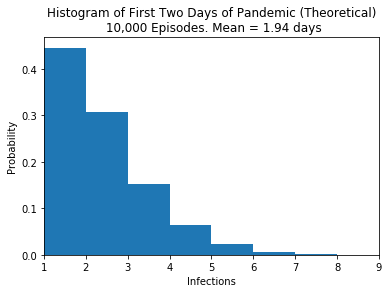

In [7]:
title = f'Histogram of First Two Days of Pandemic (Theoretical)\n 10,000 Episodes. Mean = {round(mean2, 2)} days'
plt.bar(x=np.arange(1, 21), height=probs, align='edge', width=1)
plt.title(title)
plt.xlim(left=1, right=9)
plt.xlabel('Infections')
plt.ylabel('Probability')
plt.savefig('Flu_Pandemic_Fig2.png')
plt.show()

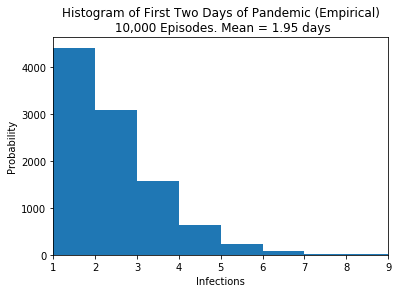

In [8]:
title = f'Histogram of First Two Days of Pandemic (Empirical)\n 10,000 Episodes. Mean = {round(expected_values[1], 2)} days'
plt.hist(day_results[:, 1], bins=range(1, 10))
plt.title(title)
plt.xlim(left=1, right=9)
plt.xlabel('Infections')
plt.ylabel('Probability')
plt.savefig('Flu_Pandemic_Fig3.png')
plt.show()

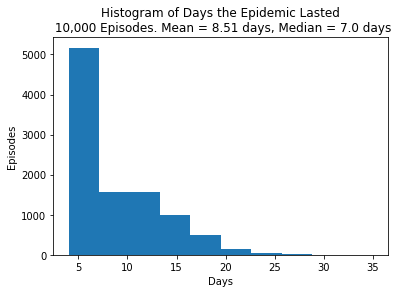

In [9]:
# Part D - Histogram
title = f'Histogram of Days the Epidemic Lasted\n 10,000 Episodes. Mean = {round(epidem_lens.mean(), 2)} days, Median = {median(epidem_lens)} days'
plt.hist(epidem_lens)
plt.title(title)
plt.xlabel('Days')
plt.ylabel('Episodes')
plt.savefig('Flu_Pandemic_Fig1.png')
plt.show()

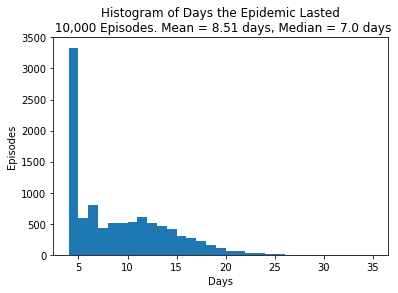

In [10]:
title = f'Histogram of Days the Epidemic Lasted\n 10,000 Episodes. Mean = {round(epidem_lens.mean(), 2)} days, Median = {median(epidem_lens)} days'
plt.hist(epidem_lens, bins=range(min(epidem_lens), max(epidem_lens)+1, 1))
plt.title(title)
plt.xlabel('Days')
plt.ylabel('Episodes')
plt.savefig('Flu_Pandemic_Fig1-smallbins.png')
plt.show()